In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, preprocessing
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, confusion_matrix
from sklearn.model_selection import KFold
from prettytable import PrettyTable

In [2]:
PATH_ROOT = os.path.join(Path().absolute().parent)
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [3]:
df_cm = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_cmeasures_nn.csv'))
df_cm = df_cm.sort_values(by=['Data', 'Rate'], ignore_index=True)
print(df_cm.shape)
print(df_cm.columns)
df_cm.head()

(2697, 34)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'HubsSD',
       'Rate', 'Filepath', 'Testpath', 'Train', 'Test'],
      dtype='object')


,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,C2,Density,ClsCoef,Hubs,HubsSD,Rate,Filepath,Testpath,Train,Test
0,f04_i02_r00_c01_w6_1,0.810730,0.372452,0.054200,0.334868,0.504,0.4245,0.030,0.200008,0.109163,...,0.077664,0.848518,0.406686,0.766283,0.302880,0.00,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_clean_...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.985,0.994
1,f04_i02_r00_c01_w6_1,0.871642,0.236221,0.157394,0.478438,0.762,0.6860,0.082,0.262551,0.115698,...,0.020594,0.862773,0.400181,0.770124,0.299065,0.05,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.934,0.994
2,f04_i02_r00_c01_w6_1,0.898315,0.188025,0.250773,0.565290,0.690,0.6360,0.126,0.264643,0.140696,...,0.278243,0.865011,0.415929,0.642544,0.312808,0.10,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.889,0.932
3,f04_i02_r00_c01_w6_1,0.924654,0.092116,0.302377,0.436307,0.690,0.6140,0.115,0.279178,0.123644,...,0.019025,0.870060,0.382698,0.761814,0.292958,0.15,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.881,0.895
4,f04_i02_r00_c01_w6_1,0.932818,0.088960,0.343645,0.512272,0.631,0.5850,0.107,0.261546,0.134748,...,0.532007,0.863499,0.437701,0.639688,0.248479,0.20,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.831,0.694


In [4]:
df_cm_rand = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_cmeasures_nn_rand.csv'))
df_cm_rand = df_cm_rand.sort_values(by=['Data', 'Rate'], ignore_index=True)
print(df_cm_rand.shape)
df_cm_rand.head()

(2700, 34)


,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,C2,Density,ClsCoef,Hubs,HubsSD,Rate,Filepath,Testpath,Train,Test
0,f04_i02_r00_c01_w6_1,0.810730,0.372452,0.054200,0.334868,0.504,0.4245,0.030,0.200008,0.109163,...,0.077664,0.848518,0.406686,0.766283,0.302880,0.00,data/synth/train/f04_i02_r00_c01_w6_1_clean_tr...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.985,0.994
1,f04_i02_r00_c01_w6_1,0.845425,0.303322,0.111632,0.769417,0.972,0.9450,0.165,0.318535,0.143255,...,0.061422,0.860539,0.411707,0.779181,0.294362,0.05,data/synth/rand/f04_i02_r00_c01_w6_1_random_0....,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.934,0.993
2,f04_i02_r00_c01_w6_1,0.881101,0.224781,0.183843,0.680190,0.976,0.9500,0.271,0.379045,0.157443,...,0.044010,0.871918,0.416944,0.782573,0.291803,0.10,data/synth/rand/f04_i02_r00_c01_w6_1_random_0....,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.894,0.993
3,f04_i02_r00_c01_w6_1,0.907517,0.180591,0.272538,0.840350,0.989,0.9780,0.381,0.411810,0.155154,...,0.035279,0.880769,0.424387,0.785371,0.296821,0.15,data/synth/rand/f04_i02_r00_c01_w6_1_random_0....,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.841,0.991
4,f04_i02_r00_c01_w6_1,0.931891,0.131553,0.372328,0.814939,0.989,0.9710,0.507,0.454593,0.153322,...,0.035279,0.888603,0.432878,0.806614,0.278477,0.20,data/synth/rand/f04_i02_r00_c01_w6_1_random_0....,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.778,0.976


In [5]:
# Split datasets into 3 difficulties
DIF_LEVELS = ['Hard', 'Normal', 'Easy']
N_BINS = len(DIF_LEVELS)
difficulty_mapping = {0: DIF_LEVELS[0], 1: DIF_LEVELS[1], 2: DIF_LEVELS[2]}

encoder = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='quantile')
acc_test_clean = df_cm[df_cm['Rate'] == 0]['Test'].to_numpy()
encoder.fit(acc_test_clean.reshape([-1, 1]))
encoder.bin_edges_ = np.array([np.array([0., 0.7, 0.9, 1.0])])

ordinal_clean = encoder.transform(acc_test_clean.reshape([-1, 1])).flatten().astype(int)

print('Convert test set accuracy into ordinal data:')
for i in range(N_BINS):
    start = encoder.bin_edges_[0][i]
    end = encoder.bin_edges_[0][i+1]
    print('{} in [{:.3f}, {:.3f})'.format(DIF_LEVELS[i], start, end))

datanames = df_cm[df_cm['Rate'] == 0]['Data'].to_numpy()
df_cm['Difficulty'] = 0
df_cm_rand
for data, dif in zip(datanames, ordinal_clean):
    idx = df_cm[df_cm['Data'] == data].index
    df_cm.loc[idx, ['Difficulty']] = dif

df_cm['Difficulty'] = df_cm['Difficulty'].replace(difficulty_mapping)

Convert test set accuracy into ordinal data:
Hard in [0.000, 0.700)
Normal in [0.700, 0.900)
Easy in [0.900, 1.000)


In [14]:
print(df_cm[df_cm['Difficulty'] == 'Easy'].shape[0])
print(df_cm[df_cm['Difficulty'] == 'Normal'].shape[0])
print(df_cm[df_cm['Difficulty'] == 'Hard'].shape[0])

180
666
1851


In [6]:
acc_test_clean = df_cm_rand[df_cm_rand['Rate'] == 0]['Test'].to_numpy()
ordinal_clean = encoder.fit_transform(acc_test_clean.reshape([-1, 1])).flatten().astype(int)
datanames = df_cm_rand[df_cm_rand['Rate'] == 0]['Data'].to_numpy()
assert len(datanames) == len(ordinal_clean)
for data, dif in zip(datanames, ordinal_clean):
    idx = df_cm_rand[df_cm_rand['Data'] == data].index
    df_cm_rand.loc[idx, ['Difficulty']] = dif

df_cm_rand['Difficulty'] = df_cm_rand['Difficulty'].replace(difficulty_mapping)

In [7]:
POISON_LVLS = np.round(np.arange(0, 0.41, 0.05, dtype=float), 2)
POISON_LVLS

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

In [8]:
col_X = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'HubsSD'
]
col_y = 'Test'

In [9]:
alpha = 0.03
N_FOLD = 5

df_cm['prediction'] = 0
df_cm_rand['prediction'] = 0

# Split by clean data
indices_clean = df_cm[df_cm['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(indices_clean):
    idx_train_clean = indices_clean[i_train]
    idx_test_clean = indices_clean[i_test]

    data_train = df_cm.loc[idx_train_clean, 'Data']
    data_test = df_cm.loc[idx_test_clean, 'Data']

    idx_train = df_cm[df_cm['Data'].isin(data_train)].index
    idx_test = df_cm[df_cm['Data'].isin(data_test)].index
    assert len(idx_train) + len(idx_test) == df_cm.shape[0]

    X_train = df_cm.loc[idx_train, col_X]
    y_train = df_cm.loc[idx_train, col_y]
    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)
    
    X_test = df_cm.loc[idx_test, col_X]
    df_cm.loc[idx_test, 'prediction'] = regressor.predict(X_test)

    # On Random noise
    X_test_rand = df_cm_rand.loc[idx_test, col_X]
    df_cm_rand.loc[idx_test, 'prediction'] = regressor.predict(X_test_rand)

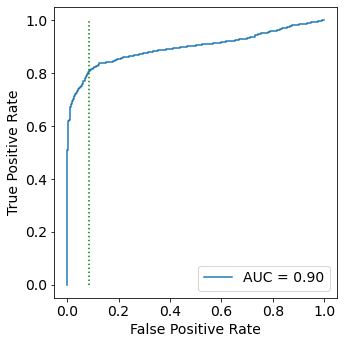

In [10]:
THRESHOLD = 0.00

FONTSIZE = 14
FIGSIZE = (5, 5)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
y_true_ = (df_cm['Rate'] > THRESHOLD).astype(int)
y_score_ = np.abs(df_cm['prediction'] - df_cm['Train'])
fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
roc_auc_ = auc(fpr, tpr)
idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
threshold = thresholds[idx_t]
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_).plot(ax=ax)
ax.vlines(threshold, 0, 1, linestyles='dotted', label='threshold', colors='green')
plt.tight_layout()
plt.show()

In [11]:
print('C-Measure threshold:', threshold)

C-Measure threshold: 0.08453348861987098


In [12]:
results = (df_cm_rand['Train'] - df_cm_rand['prediction']) > threshold
df_ = df_cm_rand[['Difficulty', 'Rate']].copy()
df_['Prediction'] = results.astype(int)
df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Noise Rate', 'Prediction': 'FPR'})
df_grouped = df_.groupby(['Dataset Difficulty', 'Noise Rate']).mean()
df_grouped = df_grouped.reset_index()
df_pivot = df_grouped.pivot('Noise Rate', 'Dataset Difficulty', 'FPR')
df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
df_pivot

Dataset Difficulty,Easy,Normal,Hard
Noise Rate,,,
0.00,0.16,0.000000,0.000000
0.05,0.59,0.206897,0.107143
0.10,0.56,0.163793,0.047619
0.15,0.43,0.103448,0.023810
0.20,0.18,0.043103,0.035714
0.25,0.03,0.017241,0.011905
0.30,0.01,0.008621,0.011905
0.35,0.00,0.000000,0.011905
0.40,0.00,0.000000,0.011905


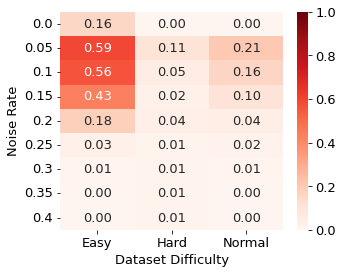

In [13]:
FONTSIZE = 13
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
df_pivot = df_grouped.pivot('Noise Rate', 'Dataset Difficulty', 'FPR')
sns.heatmap(df_pivot, ax=ax, annot=True, fmt='.2f', cmap="Reds", vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.tight_layout()
plot_output = os.path.join(PATH_ROOT, 'results', 'synth_heatmap_noise.svg')
plt.savefig(plot_output, dpi=600)
